In [1]:

import os
import cv2
import copy
import time
import random
import pickle

import numpy as np
import pandas as pd
from PIL import Image
#import seaborn as sns
from pathlib import Path
from tqdm import tqdm

from sklearn.metrics import f1_score, confusion_matrix
from numpy.random import shuffle
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.autograd.profiler as tprofiler
import torch.utils.data as td

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:

seed = 42

random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG

In [3]:
import sys
sys.path.append('../src/')

In [4]:
%load_ext autoreload
%autoreload 2

from multilabel.train import train_model
from model import initialize_model
from utils import set_requires_grad, save_model
from multilabel.data import load_data
from plotting import plot_data_loader
from multilabel.eval import eval_model

In [5]:
# Check if GPU is available.
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

# Models options: resnet50, resnet34, inceptionv3, vgg16, mobile_net_v3_large, efficient_net_b1, efficient_net_b0, efficient_net_b3.
model_name = "efficient_net_b3"

# Number of classes.
num_classes = 20

# Batch Size.
batch_size = 32

# Epochs to train for.
num_epochs = 10

# Number of workers for data loader.
num_workers = 0

# Imagenet norm array passed as default value.
# norm_arr=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Chest x-ray8 training dataset metrics 
norm_arr=((0.5989, 0.5510, 0.5175), (0.3358, 0.3330, 0.3377))

# Feature extract flag: False - Tune the whole model,
#                       True - Update only the reshaped layer parameters.
feature_extract = True

# Use pretrained flag: None - Use random weights
#                      String - Use pretrained weights given by String
use_pretrained = models.EfficientNet_B3_Weights.IMAGENET1K_V1

# Initialize the model for this run.
model_pyt, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

# lr start and end points for training.
lr_start = 0.01
lr_end = 0.001

# Print the model we just instantiated
#print(model_ft)

# Positive class weights.
pos_weight=torch.as_tensor([ 2.3509,  6.4782, 76.3264, 23.6350, 46.7897, 18.5694, 14.4224, 24.4805,
         1.1795,  0.6394,  9.1227, 80.2774,  0.8743,  2.1217,  7.2973, 87.3730,
        12.8151, 23.7444, 28.1492, 29.6749], dtype=torch.float)
pos_weight = pos_weight.to(device)

cpu


In [6]:
images_dir = "../data/processed"
data_loaders = load_data(images_dir,
                         batch_size = batch_size, 
                         input_size = input_size, 
                         norm_arr = norm_arr,
                         num_workers = num_workers)

In [7]:
class_names = data_loaders['train'].dataset.classes

In [8]:
class_names

['Active',
 'Alert',
 'Amazed',
 'Amused',
 'Calm',
 'Cheerful',
 'Confident',
 'Conscious',
 'Creative',
 'Eager',
 'Educated',
 'Emotional',
 'Fashionable',
 'Feminine',
 'Inspired',
 'Loving',
 'Manly',
 'Persuaded',
 'Thrifty',
 'Youthful']

## Efficient Net B3

In [9]:
model_pyt = model_pyt.to(device)
# load saved model directly
model_pyt.load_state_dict(torch.load('../models/augmented_efficient_net_b3_ads_100_32_0.01_0.001_model_weights.pth', map_location=device)) 

<All keys matched successfully>

In [10]:
model_pyt.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1)

In [36]:
model_pyt.features[-2][0].block[1][0]

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(232, 1392, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Conv2dNormActivation(
    (0): Conv2d(1392, 1392, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1392, bias=False)
    (1): BatchNorm2d(1392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (2): SqueezeExcitation(
    (avgpool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Conv2d(1392, 58, kernel_size=(1, 1), stride=(1, 1))
    (fc2): Conv2d(58, 1392, kernel_size=(1, 1), stride=(1, 1))
    (activation): SiLU(inplace=True)
    (scale_activation): Sigmoid()
  )
  (3): Conv2dNormActivation(
    (0): Conv2d(1392, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [12]:
def normalise(tens):
    temp = tens.detach().cpu().numpy()
    return (255*(temp - np.min(temp))/np.ptp(temp)).astype(int)   

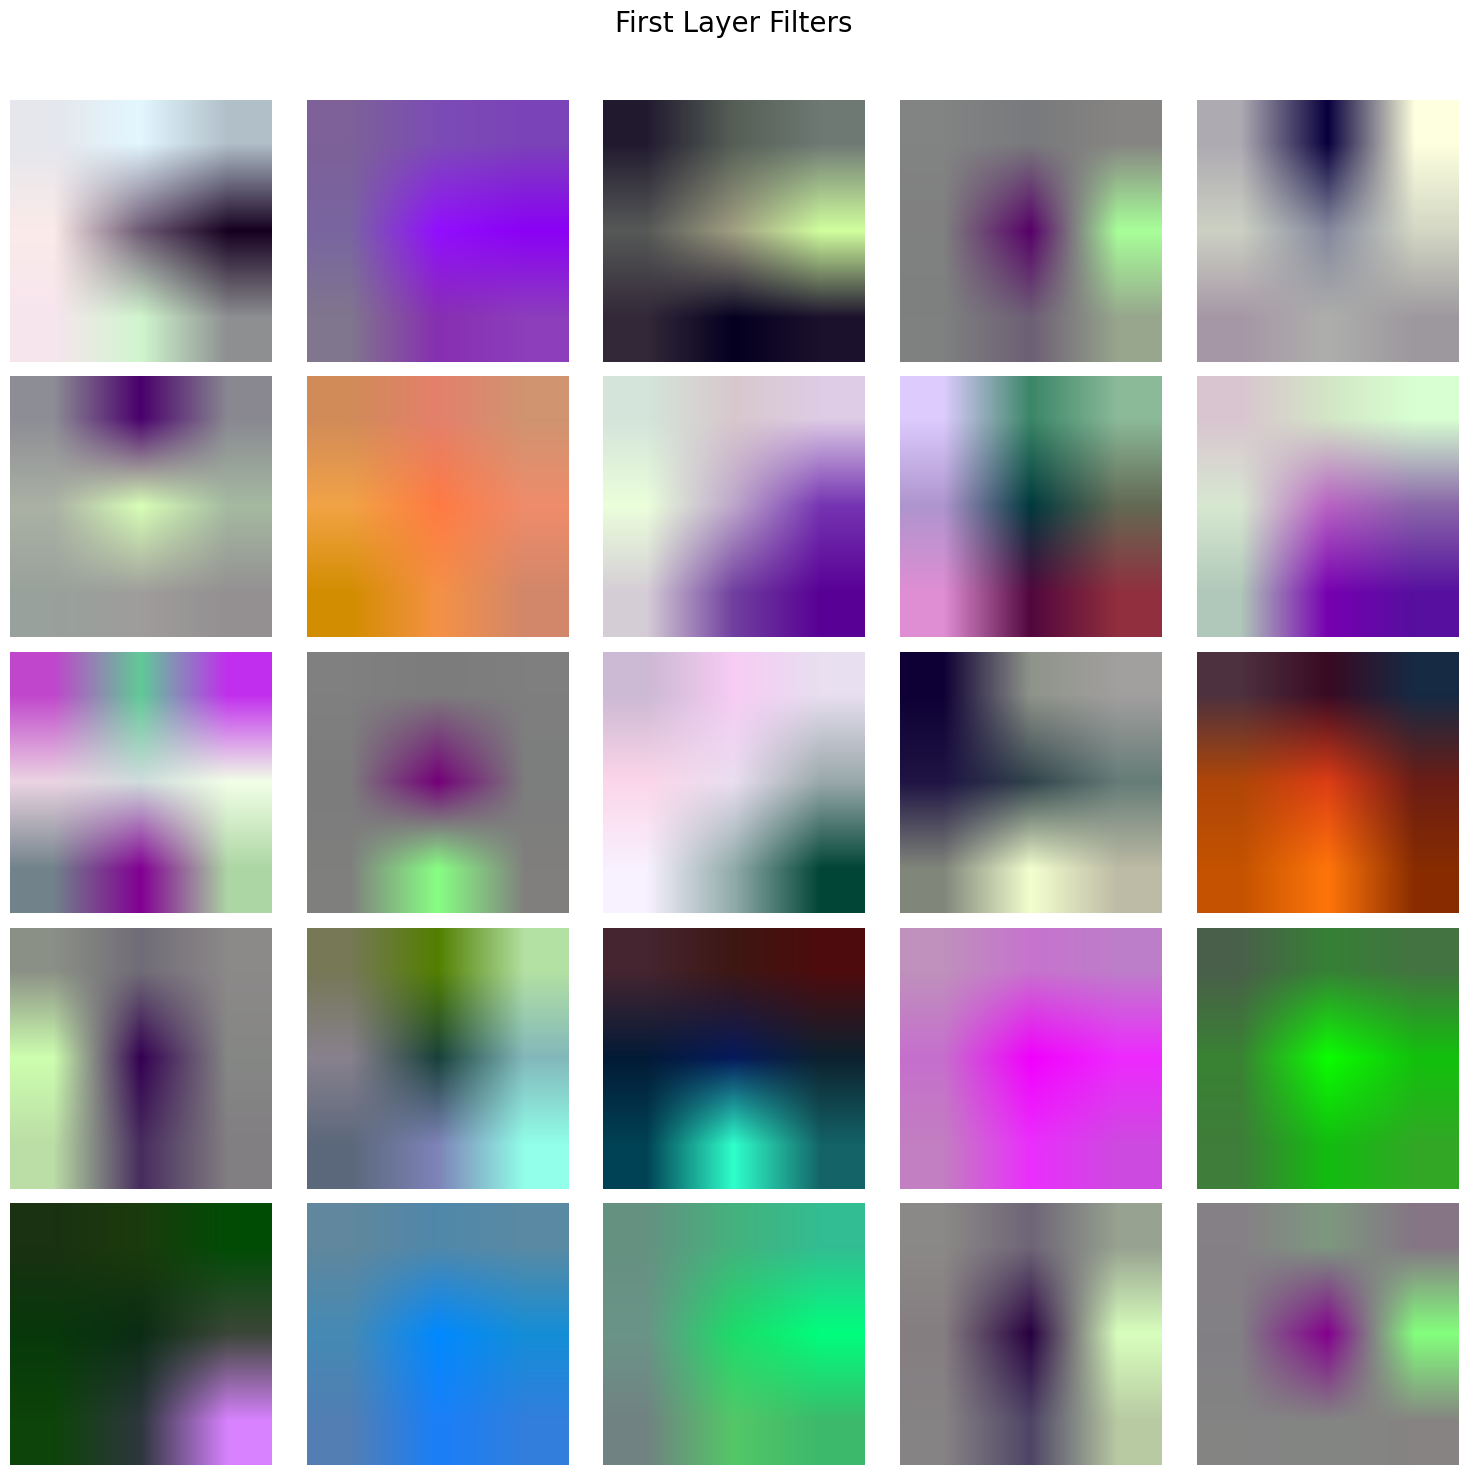

In [39]:
#weights = model_pyt.features[-3][1].block[1][0].weight
weights = model_pyt.features[0][0].weight
weights.shape
fig,axes = plt.subplots(5, 5, figsize=(15,15))
for i in range(25):
    axes.ravel()[i].axis('off')
    axes.ravel()[i].imshow(normalise(weights[i].permute(1,2,0)), interpolation = 'bilinear')
    #axes.ravel()[i].set_title(i)
fig.suptitle('First Layer Filters', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

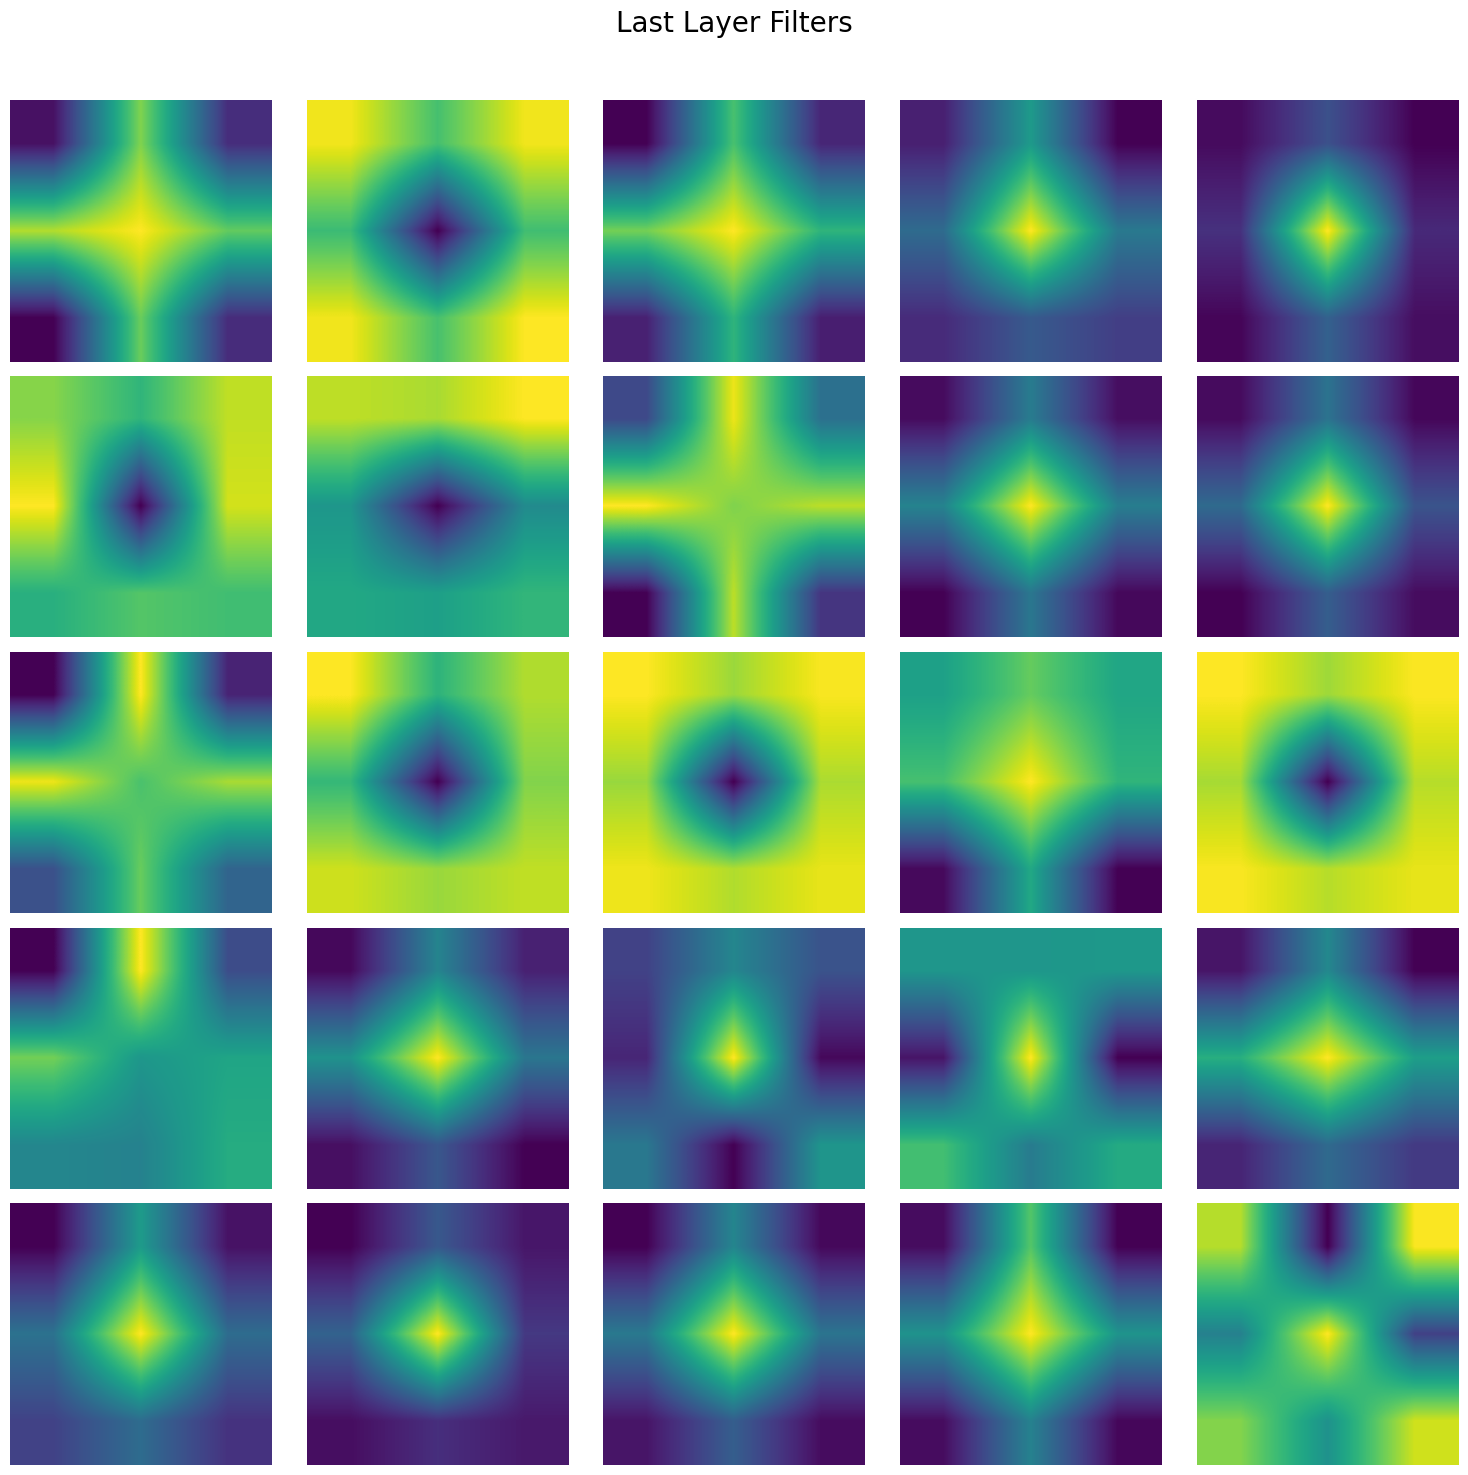

In [38]:
#weights = model_pyt.features[-3][1].block[1][0].weight
weights = model_pyt.features[-2][0].block[1][0].weight
weights.shape
fig,axes = plt.subplots(5, 5, figsize=(15,15))
for i in range(25):
    axes.ravel()[i].axis('off')
    axes.ravel()[i].imshow(normalise(weights[i].permute(1,2,0)), interpolation = 'bilinear')
    #axes.ravel()[i].set_title(i)
fig.suptitle('Last Layer Filters', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

In [40]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()
        

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [41]:
def deprocess_image(image):
    image = image.detach().cpu().numpy()
    image = np.squeeze(np.transpose(image[0], (1, 2, 0)))

    image = image * np.array((0.5989, 0.5510, 0.5175)) + \
        np.array((0.3358, 0.3330, 0.3377))  
    image = image.clip(0, 1)
    return image

In [43]:
#class_names[torch.argmax(preds).cpu()]

In [281]:
class_names

['Active',
 'Alert',
 'Amazed',
 'Amused',
 'Calm',
 'Cheerful',
 'Confident',
 'Conscious',
 'Creative',
 'Eager',
 'Educated',
 'Emotional',
 'Fashionable',
 'Feminine',
 'Inspired',
 'Loving',
 'Manly',
 'Persuaded',
 'Thrifty',
 'Youthful']

In [345]:
iterator = iter(data_loaders['test'])
next(iterator)
next(iterator)
next(iterator)
next(iterator)
next(iterator)
next(iterator)
next(iterator)
image, label = next(iterator)

In [346]:
diff_list = []
pred_list = []
ind_list = []
for idx, im in enumerate(image):
    top_preds, top_ind= torch.topk(model_pyt.eval()(im.unsqueeze(0)).sigmoid()[0], 4)
    top_preds = np.round(top_preds.detach().cpu().detach().numpy(), 2)
    top_ind = top_ind.tolist()
    pred_list.append(top_preds)
    ind_list.append(top_ind)
    diff_list.append(top_preds[0] - top_preds[1])
print(diff_list.index(max(diff_list)))
print({idx: itm for idx, itm in enumerate(diff_list)})

31
{0: 0.06999999, 1: 0.0, 2: 0.09, 3: 0.22000003, 4: 0.00999999, 5: 0.28000003, 6: 0.030000001, 7: 0.13999999, 8: 0.14999998, 9: 0.32999998, 10: 0.16999996, 11: 0.050000012, 12: 0.45, 13: 0.13, 14: 0.030000001, 15: 0.110000014, 16: 0.13, 17: 0.32, 18: 0.24000001, 19: 0.29000002, 20: 0.43, 21: 0.22999999, 22: 0.16000003, 23: 0.3, 24: 0.13, 25: 0.21000001, 26: 0.060000032, 27: 0.32999998, 28: 0.36, 29: 0.34, 30: 0.060000002, 31: 0.48000002}


In [347]:
label

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0

In [348]:
preds = pd.DataFrame(pred_list)
preds['Diff'] = preds[0]-preds[1]
preds['Ind'] = ind_list
preds['Actual'] = label
preds.sort_values('Diff', ascending=False)

0     1     2     3  Diff               Ind  \
31  0.91  0.43  0.23  0.17  0.48     [15, 9, 5, 3]   
12  0.99  0.54  0.48  0.45  0.45  [15, 12, 13, 16]   
20  0.79  0.36  0.28  0.26  0.43     [3, 8, 0, 16]   
28  0.74  0.38  0.28  0.24  0.36    [0, 12, 6, 14]   
29  0.81  0.47  0.29  0.23  0.34    [12, 13, 7, 6]   
9   0.64  0.31  0.28  0.23  0.33     [9, 1, 3, 14]   
27  0.71  0.38  0.23  0.18  0.33     [9, 15, 7, 8]   
17  0.89  0.57  0.31  0.15  0.32    [13, 12, 5, 3]   
23  0.62  0.32  0.27  0.17  0.30     [0, 1, 14, 8]   
19  0.99  0.70  0.69  0.67  0.29     [19, 5, 3, 9]   
5   0.80  0.52  0.44  0.42  0.28   [2, 17, 14, 11]   
18  0.67  0.43  0.34  0.32  0.24   [16, 6, 12, 10]   
21  0.48  0.25  0.16  0.15  0.23     [9, 8, 6, 17]   
3   0.99  0.77  0.75  0.57  0.22   [15, 13, 12, 4]   
25  0.68  0.47  0.41  0.39  0.21    [10, 7, 1, 14]   
10  0.84  0.67  0.58  0.46  0.17    [19, 18, 5, 9]   
22  0.79  0.63  0.60  0.57  0.16     [0, 19, 7, 1]   
8   0.89  0.74  0.61  0.54  0.15     [15, 6, 1, 0]   
7   0.76  0.62  0.56  0.49  0.14   [11, 10, 17, 5]   
24  0.83  0.70  0.45  0.38  0.13    [12, 16, 6, 5]   
16  0.77  0.64  0.49  0.45  0.13     [3, 1, 7, 10]   
13  0.63  0.50  0.35  0.34  0.13   [18, 11, 8, 17]   
15  0.85  0.74  0.47  0.42  0.11     [2, 15, 1, 3]   
2   0.40  0.31  0.28  0.24  0.09    [5, 1, 16, 12]   
0   0.84  0.77  0.70  0.44  0.07     [1, 7, 14, 8]   
26  0.54  0.48  0.33  0.30  0.06     [18, 5, 9, 8]   
30  0.79  0.73  0.32  0.26  0.06   [13, 12, 11, 5]   
11  0.81  0.76  0.43  0.42  0.05     [19, 7, 5, 8]   
14  0.41  0.38  0.30  0.25  0.03      [9, 3, 8, 1]   
6   0.47  0.44  0.27  0.21  0.03   [13, 10, 12, 1]   
4   0.93  0.92  0.51  0.38  0.01    [12, 13, 6, 5]   
1   0.48  0.48  0.46  0.40  0.00   [18, 17, 1, 14]   

                                               Actual  
31  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
12  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
20  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
28  (tensor(1.), tensor(0.), tensor(0.), tensor(0....  
29  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
9   (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
27  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
17  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
23  (tensor(1.), tensor(0.), tensor(0.), tensor(0....  
19  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
5   (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
18  (tensor(0.), tensor(1.), tensor(0.), tensor(0....  
21  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
3   (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
25  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
10  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
22  (tensor(1.), tensor(0.), tensor(0.), tensor(0....  
8   (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
7   (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
24  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
16  (tensor(0.), tensor(1.), tensor(0.), tensor(0....  
13  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
15  (tensor(1.), tensor(0.), tensor(0.), tensor(0....  
2   (tensor(0.), tensor(1.), tensor(0.), tensor(0....  
0   (tensor(0.), tensor(1.), tensor(0.), tensor(0....  
26  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
30  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
11  (tensor(0.), tensor(1.), tensor(0.), tensor(0....  
14  (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
6   (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
4   (tensor(0.), tensor(0.), tensor(0.), tensor(0....  
1   (tensor(0.), tensor(0.), tensor(0.), tensor(0....

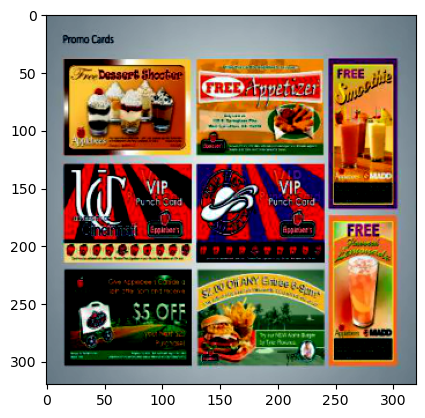

In [353]:
#2, 26, 21, 10
image_idx = 13
image1 = image[image_idx].to(device)
label1 = label[image_idx].to(device)
plt.imshow(deprocess_image(image1.unsqueeze(0)))

In [354]:
label1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [355]:
label1.argmax()

tensor(9)

In [356]:
class_names[17]

'Persuaded'

In [357]:
model_pyt.requires_grad_()
image1.requires_grad_();

In [358]:
model_pyt.features[1][0].block[0][0]

Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)

First layer

In [359]:
# Last layer - model_pyt.features[-2][0].block[0][0]
grads = []
for cls in range(20):
    with HookBwd(model_pyt.features[2][0].block[0][0]) as hookb:
        with Hook(model_pyt.features[2][0].block[0][0]) as hookf:
            output = model_pyt.eval()(image1.unsqueeze(0))
            act = hookf.stored
        output[0, cls].backward()
        grads.append(hookb.stored)

c:\Other\miniconda3\envs\py38\lib\site-packages\torch\nn\modules\module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


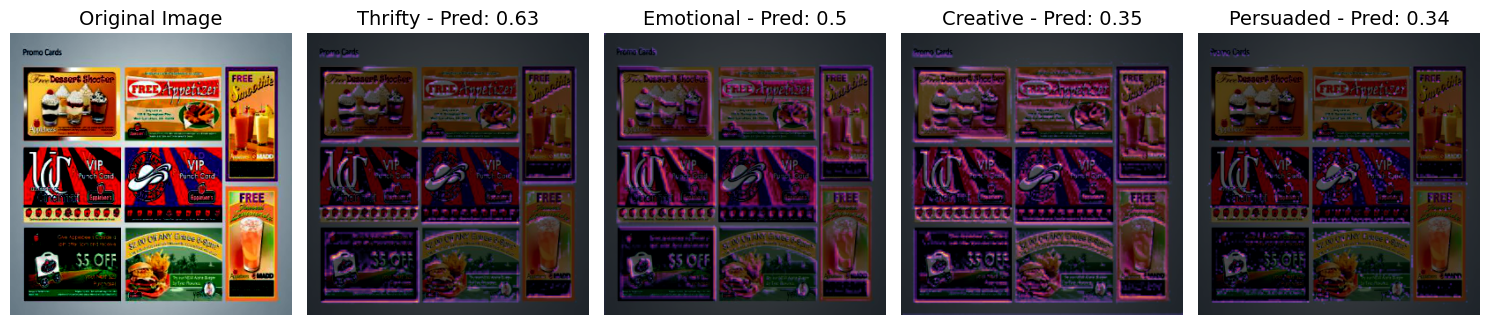

In [360]:
cam_maps = []
for i in range(20):
    w = grads[i][0].mean(dim=[1,2], keepdim = True)
    cam_maps.append(F.relu((w*act[0]).sum(0)))
top_preds, top_ind= torch.topk(model_pyt.eval()(image1.unsqueeze(0)).sigmoid()[0], 4)
top_preds = np.round(top_preds.detach().cpu().detach().numpy(), 2)
top_ind = top_ind.tolist()

fig,ax = plt.subplots(1,5, figsize = (15,10))
for i, ind in enumerate(top_ind, start = 1):
    ax.ravel()[i].imshow(deprocess_image(image1.unsqueeze(0)))
    ax.ravel()[i].imshow(cam_maps[ind].detach().cpu(), alpha = 0.7, extent = (0,320,320,0), interpolation = 'bilinear', cmap = 'magma')
    ax.ravel()[i].set_title(class_names[ind] + " - Pred: " + str(top_preds[i-1]), size = 14)
    ax.ravel()[i].axis('off')
    #ax.ravel()[i].text(200, 30,'Pred: ' + str(top_preds[i-1]), color = 'blue', size = 14)

ax.ravel()[0].axis('off')
ax.ravel()[0].set_title("Original Image", size = 14)
ax.ravel()[0].imshow(deprocess_image(image1.unsqueeze(0)))
fig.tight_layout()
fig.savefig("9_Layer_first.eps", format="eps", dpi=300, bbox_inches="tight", transparent=True)

Middle Layer

In [361]:
# Last layer - model_pyt.features[-2][0].block[0][0]
grads = []
for cls in range(20):
    with HookBwd(model_pyt.features[5][0].block[0][0]) as hookb:
        with Hook(model_pyt.features[5][0].block[0][0]) as hookf:
            output = model_pyt.eval()(image1.unsqueeze(0))
            act = hookf.stored
        output[0, cls].backward()
        grads.append(hookb.stored)

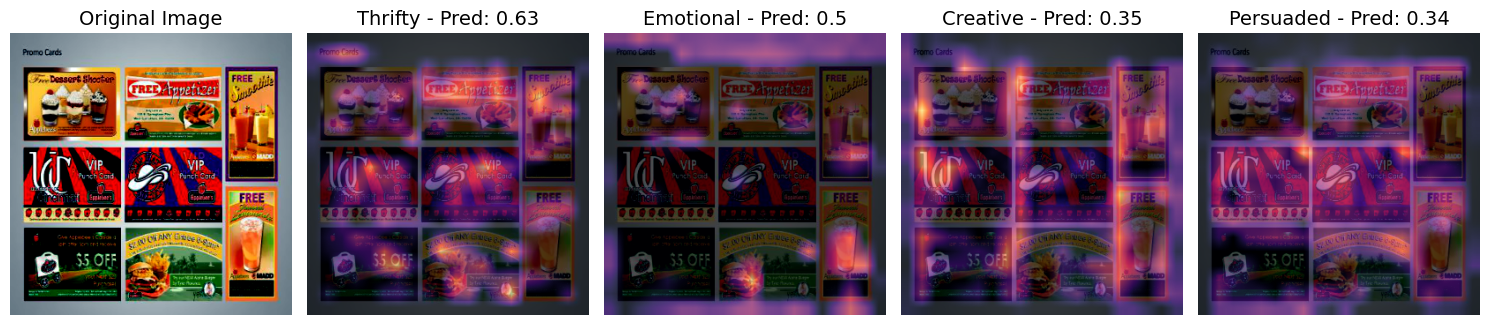

In [362]:
cam_maps = []
for i in range(20):
    w = grads[i][0].mean(dim=[1,2], keepdim = True)
    cam_maps.append(F.relu((w*act[0]).sum(0)))
top_preds, top_ind= torch.topk(model_pyt.eval()(image1.unsqueeze(0)).sigmoid()[0], 4)
top_preds = np.round(top_preds.detach().cpu().detach().numpy(), 2)
top_ind = top_ind.tolist()

fig,ax = plt.subplots(1,5, figsize = (15,10))
for i, ind in enumerate(top_ind, start = 1):
    ax.ravel()[i].imshow(deprocess_image(image1.unsqueeze(0)))
    ax.ravel()[i].imshow(cam_maps[ind].detach().cpu(), alpha = 0.7, extent = (0,320,320,0), interpolation = 'bilinear', cmap = 'magma')
    ax.ravel()[i].set_title(class_names[ind] + " - Pred: " + str(top_preds[i-1]), size = 14)
    ax.ravel()[i].axis('off')
    #ax.ravel()[i].text(200, 30,'Pred: ' + str(top_preds[i-1]), color = 'blue', size = 14)

ax.ravel()[0].axis('off')
ax.ravel()[0].set_title("Original Image", size = 14)
ax.ravel()[0].imshow(deprocess_image(image1.unsqueeze(0)))
fig.tight_layout()
fig.savefig("9_Layer_middle.eps", format="eps", dpi=300, bbox_inches="tight", transparent=True)

Last Layer

In [363]:
# Last layer - model_pyt.features[-2][0].block[0][0]
grads = []
for cls in range(20):
    with HookBwd(model_pyt.features[-2][0].block[0][0]) as hookb:
        with Hook(model_pyt.features[-2][0].block[0][0]) as hookf:
            output = model_pyt.eval()(image1.unsqueeze(0))
            act = hookf.stored
        output[0, cls].backward()
        grads.append(hookb.stored)

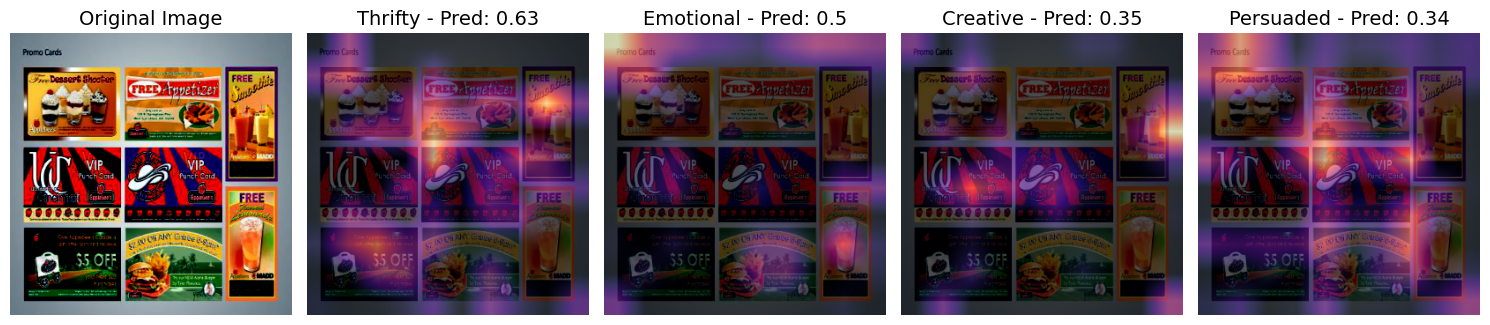

In [364]:
cam_maps = []
for i in range(20):
    w = grads[i][0].mean(dim=[1,2], keepdim = True)
    cam_maps.append(F.relu((w*act[0]).sum(0)))
top_preds, top_ind= torch.topk(model_pyt.eval()(image1.unsqueeze(0)).sigmoid()[0], 4)
top_preds = np.round(top_preds.detach().cpu().detach().numpy(), 2)
top_ind = top_ind.tolist()

fig,ax = plt.subplots(1,5, figsize = (15,10))
for i, ind in enumerate(top_ind, start = 1):
    ax.ravel()[i].imshow(deprocess_image(image1.unsqueeze(0)))
    ax.ravel()[i].imshow(cam_maps[ind].detach().cpu(), alpha = 0.7, extent = (0,320,320,0), interpolation = 'bilinear', cmap = 'magma')
    ax.ravel()[i].set_title(class_names[ind] + " - Pred: " + str(top_preds[i-1]), size = 14)
    ax.ravel()[i].axis('off')
    #ax.ravel()[i].text(200, 30,'Pred: ' + str(top_preds[i-1]), color = 'blue', size = 14)

ax.ravel()[0].axis('off')
ax.ravel()[0].set_title("Original Image", size = 14)
ax.ravel()[0].imshow(deprocess_image(image1.unsqueeze(0)))
fig.tight_layout()
fig.savefig("9_Layer_last.eps", format="eps", dpi=300, bbox_inches="tight", transparent=True)

In [29]:
#import warnings
#warnings.filterwarnings("ignore")

for i in range(len(image)):

  image1 = image[i].to(device)
  label1 = label[i].to(device)

  #sample_fname, _ = data_loaders['test'].dataset.samples[i]
  image1 = image1.view(1, 3, 320, 320)


  cam_obj = GradCAM(model=model_pyt, target_layer=model_pyt.features[-1]) 
  _, efficient_cam = cam_obj(image1, label1)

  image1 = deprocess_image(image1)
  eff_img = apply_mask(image1, efficient_cam)[:, :, ::-1]

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

  plt.setp((ax1,ax2), xticks=[],yticks=[])

  ax1.imshow(image1)
  ax1.set_xlabel(str(class_names[label1.item()]) +" (original)")
  ax1.set_title("Class:"+str(class_names[label1.item()]))
  ax2.imshow(eff_img)
  ax2.set_xlabel("EFFICIENTNET")

  plt.subplots_adjust(wspace=0.00, hspace=0.00)

IndexError: tensors used as indices must be long, byte or bool tensors

In [30]:
label1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0')

In [74]:
model_pyt.features[1][0].block[0][0]

Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)